In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 25

In [2]:
# ----- Set parameters -----
touch_col_prepend = 'touch'
direct_label = 'direct'
first_weight = 0.4
last_weight = 0.4
cred_col_post_pend = '_credit'
select_model_types = ['last_touch_point', 'first_touch_point', 'last_nondirect_touch_point', 'linear', 'position']    # options are ['last_touch_point', 'first_touch_point', 'last_nondirect_touch_point', 'linear', 'position']
write_to_file = True


In [3]:
# ----- Import data -----
#df = pd.read_pickle('attribution_allocation_student_data')
#channel_spend = pd.read_pickle('channel_spend_student_data')
df = pd.read_csv('attribution_allocation_student_data.csv')
channel_spend = pd.read_csv('channel_spend_student_data.csv')
print(df.shape)
print(channel_spend.shape)

(68124, 7)
(3, 2)


In [4]:
df.head()

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier
0,True,referral,referral,referral,email,NaN,1
1,True,referral,display,display,email,NaN,1
2,True,email,display,referral,NaN,NaN,1
3,True,referral,referral,email,NaN,NaN,1
4,True,social,referral,NaN,NaN,NaN,1


In [5]:
import json
channel_spend = pd.read_csv('channel_spend_student_data.csv')
json.loads(channel_spend['0'][0].replace("'", '"'))

{'email': 1000.0,
 'social': 1000.0000000000001,
 'display': 1000.0,
 'paid_search': 999.9999999999999,
 'referral': 1000.0,
 'organic_search': 0.0,
 'direct': 0.0}

In [6]:
channel_spend_dict = {}
tier_list = ['tier1', 'tier2', 'tier3']
for i in range(3):
    channel_spend_dict[tier_list[i]] = json.loads(channel_spend['0'][i].replace("'", '"'))
# channel_spend_dict
channel_spend = channel_spend_dict

In [7]:
channel_spend['tier1'].keys()

dict_keys(['email', 'social', 'display', 'paid_search', 'referral', 'organic_search', 'direct'])

In [8]:
# ----- Calculations -----
touch_col_names = [x for x in df.columns if x.find(touch_col_prepend) > -1]
max_touches = max([int(x.split(touch_col_prepend)[1]) for x in touch_col_names])

# total spending for all three tier experiments
channel_spend['total'] = dict()
for t_name, t in channel_spend.items():
    if t_name != 'total':
        for c in t.keys():
            try:
                channel_spend['total'][c] = channel_spend['total'][c] + t[c]
            except KeyError:
                channel_spend['total'].update({c: 0})


In [9]:
channel_spend['total']

{'email': 5000.0,
 'social': 5000.0,
 'display': 5000.0,
 'paid_search': 5000.0,
 'referral': 5000.0,
 'organic_search': 0.0,
 'direct': 0.0}

In [10]:
# ----- Format dataframe -----
# --- create credit columns
base_set = set()
[base_set.update(set(df[x].dropna().unique())) for x in touch_col_names]
cred_col_names = [x + '_credit' for x in base_set]
df = pd.concat([df, pd.DataFrame(data=0, columns=cred_col_names, index=df.index)], axis=1, ignore_index=False)


In [26]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

Counter(list(df['touch1']) + list(df['touch2']) + list(df['touch3']) + list(df['touch4']) + list(df['touch5']))

Counter({'referral': 136289,
         'email': 13296,
         'social': 20343,
         'paid_search': 4745,
         'display': 23191,
         'organic_search': 239,
         'direct': 130,
         nan: 142387})

In [69]:
CAC_dfs['last_touch_point'].reset_index()

,index,marginal_conversions_t1,marginal_spend_t1,marginal_CAC_t1,marginal_conversions_t2,marginal_spend_t2,marginal_CAC_t2,marginal_conversions_t3,marginal_spend_t3,marginal_CAC_t3
0,social,625.0,1000.0,1.600000,435.0,1000.0,2.298851,215.0,1000.0,4.651163
1,display,528.0,1000.0,1.893939,290.0,1000.0,3.448276,128.0,1000.0,7.812500
2,referral,1211.0,1000.0,0.825764,896.0,1000.0,1.116071,589.0,1000.0,1.697793
3,direct,1.0,0.0,0.000000,0.0,0.0,NaN,4.0,0.0,0.000000
4,organic_search,2.0,0.0,0.000000,2.0,0.0,0.000000,1.0,0.0,0.000000
5,email,281.0,1000.0,3.558719,274.0,1000.0,3.649635,100.0,1000.0,10.000000
6,paid_search,176.0,1000.0,5.681818,171.0,1000.0,5.847953,134.0,1000.0,7.462687


In [74]:
tmp_dict = dict(Counter(list(df['touch1']) + list(df['touch2']) + list(df['touch3']) + list(df['touch4']) + list(df['touch5'])))
tmp_df = pd.DataFrame()
tmp_df['channels'] = tmp_dict.keys()
tmp_df['reach'] = tmp_dict.values()

tmp_dict = dict(df[df.convert_TF==True].last_touch_point.value_counts())
tmp_df2 = pd.DataFrame()
tmp_df2['channels'] = tmp_dict.keys()
tmp_df2['convert'] = tmp_dict.values()

tmp_df = tmp_df.merge(tmp_df2, on='channels')
tmp_df['CVR_CTR'] = tmp_df['convert']/tmp_df['reach']

tmp_df = tmp_df.merge(CAC_dfs['last_touch_point'][['marginal_CAC_t1', 'marginal_CAC_t2', 'marginal_CAC_t3']].reset_index(), left_on='channels', right_on='index')
tmp_df
# plt.figure(figsize=(15,7))
# sns.barplot(x='channels', y='reach', data=tmp_df)

,channels,reach,convert,CVR_CTR,index,marginal_CAC_t1,marginal_CAC_t2,marginal_CAC_t3
0,referral,136289,6014,0.044127,referral,0.825764,1.116071,1.697793
1,email,13296,1491,0.112139,email,3.558719,3.649635,10.000000
2,social,20343,2960,0.145505,social,1.600000,2.298851,4.651163
3,paid_search,4745,1004,0.211591,paid_search,5.681818,5.847953,7.462687
4,display,23191,2292,0.098831,display,1.893939,3.448276,7.812500
5,organic_search,239,11,0.046025,organic_search,0.000000,0.000000,0.000000
6,direct,130,7,0.053846,direct,0.000000,NaN,0.000000


In [75]:
tmp_df.to_excel('reach_convert.xlsx')

In [54]:
df[df.convert_TF==True].touch1.value_counts()

referral          7495
social            2280
display           2031
email             1284
paid_search        668
organic_search      15
direct               6
Name: touch1, dtype: int64

In [45]:
df

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier,social_credit,display_credit,referral_credit,direct_credit,organic_search_credit,email_credit,paid_search_credit,last_touch_point,first_touch_point,last_nondirect_touch_point
0,True,referral,referral,referral,email,NaN,1,0.0,0.0,0.6,0.0,0.0,0.4,0.0,email,referral,email
1,True,referral,display,display,email,NaN,1,0.0,0.2,0.4,0.0,0.0,0.4,0.0,email,referral,email
2,True,email,display,referral,NaN,NaN,1,0.0,0.2,0.4,0.0,0.0,0.4,0.0,referral,email,referral
3,True,referral,referral,email,NaN,NaN,1,0.0,0.0,0.6,0.0,0.0,0.4,0.0,email,referral,email
4,True,social,referral,NaN,NaN,NaN,1,0.5,0.0,0.5,0.0,0.0,0.0,0.0,referral,social,referral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68119,False,social,display,direct,NaN,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,social,display
68120,False,referral,referral,referral,referral,direct,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,referral,referral
68121,False,display,referral,social,direct,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,display,social
68122,False,email,email,social,direct,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,email,social


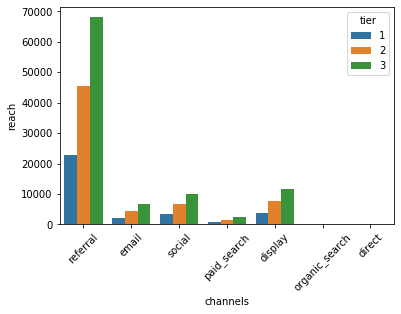

In [50]:
df_all = pd.DataFrame()
for i in [1,2,3]:
    df_tier = df[df.tier==i]
    tmp_dict = dict(Counter(list(df_tier['touch1']) + list(df_tier['touch2']) + list(df_tier['touch3']) + list(df_tier['touch4']) + list(df_tier['touch5'])))
    tmp_df = pd.DataFrame()
    tmp_df['channels'] = tmp_dict.keys()
    tmp_df['reach'] = tmp_dict.values()
    tmp_df['tier'] = i
    df_all = pd.concat([df_all, tmp_df], axis=0)
    
plt.figure(figsize=(6,4))
plt.xticks(rotation=45)

sns.barplot(x='channels', y='reach', hue='tier', data=df_all)



In [41]:
for i in [1,2,3]:
    print(i, df[df.tier==i].convert_TF.value_counts())

1 False    8530
True     2824
Name: convert_TF, dtype: int64
2 False    17816
True      4892
Name: convert_TF, dtype: int64
3 False    27999
True      6063
Name: convert_TF, dtype: int64


In [12]:

def find_last_touchpoint(t_row, touch_col_prepend_f, max_touches_f):
    for t in range(max_touches_f, 0, -1):
        t_val = t_row[touch_col_prepend_f + str(t)]
        try:
            if isinstance(t_val, str):
                return t_val
        except:
            None
    return None


def find_first_touchpoint(t_row, touch_col_prepend_f, max_touches_f):
    for t in range(1, max_touches_f + 1):
        t_val = t_row[touch_col_prepend_f + str(t)]
        try:
            if isinstance(t_val, str):
                return t_val
        except:
            None
    return None


def find_last_nondirect_touchpoint(t_row, touch_col_prepend_f, max_touches_f, direct_label_f):
    for t in range(max_touches_f, 0, -1):
        t_val = t_row[touch_col_prepend_f + str(t)]
        try:
            if isinstance(t_val, str) and t_val != direct_label_f:
                return t_val
        except:
            None
    return None


def assign_credit(t_row, cred_col_names_f, touch_col_names_f, cred_col_post_pend_f, model_type_f, first_weight_f=0.5, last_weight_f=0.5):
    # function assigns a credit to each relevant channel based on user specified model type, e.g. "last_touch_point", "first_touch_point", etc.
    t_dict = dict(zip(cred_col_names_f, [0]*len(cred_col_names_f)))

    if model_type_f == 'last_touch_point':
        # last
        t_dict.update({t_row['last_touch_point'] + cred_col_post_pend_f: 1})
        return t_dict
    elif model_type_f == 'first_touch_point':
        # first
        t_dict.update({t_row['first_touch_point'] + cred_col_post_pend_f: 1})
        return t_dict
    elif model_type_f == 'last_nondirect_touch_point':
        # last_non_direct
        try:
            t_dict.update({t_row['last_nondirect_touch_point'] + cred_col_post_pend_f: 1})
            return t_dict
        except TypeError:
            # case where there is no other channel
            t_dict.update({'direct' + cred_col_post_pend_f: 1})
            return t_dict
    elif (model_type_f == 'linear') or (model_type_f == 'position'):
        # linear and position based
        t_channels = [x for x in t_row[touch_col_names_f] if isinstance(x, str)]
        if model_type_f == 'linear':
            # linear weights
            t_weights = [1 / len(t_channels)] * len(t_channels)
        elif model_type_f == 'position':
            # position based weights (first and last specified, middle divided evenly)
            if len(t_channels) > 2:
                t_weights = [first_weight_f] + [(1 - (first_weight_f + last_weight_f)) / (len(t_channels) - 2)] * (len(t_channels) - 2) + [last_weight_f]
            elif len(t_channels)==1:
                t_weights = [1]
            else:
                t_weights = [first_weight_f] + [last_weight_f]

        t_weights = [x / sum(t_weights) for x in t_weights]     # ensure weights sum to 1
        for i in range(0, len(t_weights)):
            t_key = t_channels[i] + '_credit'
            t_value = t_dict[t_key] + t_weights[i]
            t_dict.update({t_key: t_value})
        return t_dict
    else:
        return t_dict


def get_attribution_by_channel(df_f, credit_col_postpend_f):
    allocated_conversions = df_f[cred_col_names].sum()
    n_allocated_conversions = df_f[cred_col_names].sum().sum()
    n_total_conversions = df_f.convert_TF.sum()
    if n_allocated_conversions != n_total_conversions:
        print('WARNING: allocation error. Sum of allocated conversions = %d. Sum of total conversions = %d' % (int(n_allocated_conversions), int(n_total_conversions)))

    channel_allocation_f = pd.Series(dict(zip([x.split(credit_col_postpend_f)[0] for x in allocated_conversions.keys()], list(allocated_conversions.array))))
    return channel_allocation_f


def calc_avg_CAC(channel_allocation_f, channel_spend_f):
    t_df = pd.DataFrame(channel_allocation_f)
    t_df.columns = ['channel_allocation']
    for t_ind, _ in t_df.iterrows():
        t_df.loc[t_ind, 'channel_spend'] = channel_spend_f[t_ind]

    t_df['CAC'] = t_df['channel_spend'] / t_df['channel_allocation']
    t_df['CAC'].replace(np.inf, 0, inplace=True)
    return t_df


def calc_marginal_CAC(n_conversions_low_tier, spend_low_tier, n_conversions_high_tier, spend_high_tier):
    ##### fill in this code to create the three variables in output dictionary
    marginal_conversions = n_conversions_high_tier - n_conversions_low_tier
    marginal_spend = spend_high_tier - spend_low_tier
    marginal_CAC = marginal_spend/marginal_conversions
    return {'marginal_conversions': marginal_conversions, 'marginal_spend': marginal_spend,
            'marginal_CAC': marginal_CAC}



In [13]:
# --- identify key touch points
df['last_touch_point'] = df.apply(find_last_touchpoint, args=(touch_col_prepend, max_touches), axis=1)
df['first_touch_point'] = df.apply(find_first_touchpoint, args=(touch_col_prepend, max_touches), axis=1)
df['last_nondirect_touch_point'] = df.apply(find_last_nondirect_touchpoint, args=(touch_col_prepend, max_touches, direct_label,), axis=1)


In [14]:
df

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier,social_credit,display_credit,referral_credit,direct_credit,organic_search_credit,email_credit,paid_search_credit,last_touch_point,first_touch_point,last_nondirect_touch_point
0,True,referral,referral,referral,email,NaN,1,0,0,0,0,0,0,0,email,referral,email
1,True,referral,display,display,email,NaN,1,0,0,0,0,0,0,0,email,referral,email
2,True,email,display,referral,NaN,NaN,1,0,0,0,0,0,0,0,referral,email,referral
3,True,referral,referral,email,NaN,NaN,1,0,0,0,0,0,0,0,email,referral,email
4,True,social,referral,NaN,NaN,NaN,1,0,0,0,0,0,0,0,referral,social,referral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68119,False,social,display,direct,NaN,NaN,3,0,0,0,0,0,0,0,direct,social,display
68120,False,referral,referral,referral,referral,direct,3,0,0,0,0,0,0,0,direct,referral,referral
68121,False,display,referral,social,direct,NaN,3,0,0,0,0,0,0,0,direct,display,social
68122,False,email,email,social,direct,NaN,3,0,0,0,0,0,0,0,direct,email,social


In [15]:
# df = df.sample(n=5000)
# ----- RUN MODELS -----
CAC_dfs = dict()
for model_type in select_model_types:
    print('Processing model %s' % model_type)

    # ----- Run attribution model -----
    print('Running attribution model')
    df_convert = df.loc[df.convert_TF]  # only run calculation for conversion rows
    for t_ind, t_row in df_convert.iterrows():
        t_credit_dict = assign_credit(t_row, cred_col_names, touch_col_names, cred_col_post_pend, model_type, first_weight, last_weight)
        df.loc[t_ind, list(t_credit_dict.keys())] = list(t_credit_dict.values())  # add credit to original dataframe
    del df_convert, t_ind, t_row

    # ----- Calculate CAC -----
    print('Calculating average and marginal CAC')
    # --- Average CAC ---
    channel_allocation = get_attribution_by_channel(df, credit_col_postpend_f='_credit')
    df_CAC = calc_avg_CAC(channel_allocation_f=channel_allocation, channel_spend_f=channel_spend['total'])

    # --- Marginal CAC ---
    credit_cols = [x for x in df.columns if x.find('credit') > -1]
    df_CAC = pd.DataFrame(index=[x.split('_credit')[0] for x in credit_cols])
    base_col_names = ['marginal_conversions', 'marginal_spend', 'marginal_CAC']

    df_tier_sum = df[['tier']+credit_cols].groupby(['tier']).sum()
    df_tier_sum.columns = [x.split('_credit')[0] for x in df_tier_sum.columns]
    for t_tier in df_tier_sum.index:
        for t_channel in df_CAC.index:
            if t_tier > 1:
                n_conversions_low_tier = df_tier_sum.loc[t_tier - 1, t_channel]
                spend_low_tier = channel_spend['tier' + str(t_tier - 1)][t_channel]
                n_conversions_high_tier = df_tier_sum.loc[t_tier, t_channel]
                spend_high_tier = channel_spend['tier' + str(t_tier)][t_channel]
            else:
                n_conversions_low_tier = 0
                spend_low_tier = 0
                n_conversions_high_tier = df_tier_sum.loc[t_tier, t_channel]
                spend_high_tier = channel_spend['tier' + str(t_tier)][t_channel]

            t_df_CAC_colnames = [x + '_t' + str(t_tier) for x in base_col_names]
            
            for i in t_df_CAC_colnames:
                if i not in list(df_CAC.columns):
                    df_CAC[i] = float('nan')
            
            t_marginal_dict = calc_marginal_CAC(n_conversions_low_tier, spend_low_tier, n_conversions_high_tier, spend_high_tier)
            df_CAC.loc[t_channel, t_df_CAC_colnames] = [t_marginal_dict[x] for x in base_col_names]

    CAC_dfs.update({model_type: df_CAC})

Processing model last_touch_point
Running attribution model
Calculating average and marginal CAC
Processing model first_touch_point
Running attribution model


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


Calculating average and marginal CAC
Processing model last_nondirect_touch_point
Running attribution model
Calculating average and marginal CAC
Processing model linear
Running attribution model
Calculating average and marginal CAC
Processing model position
Running attribution model
Calculating average and marginal CAC


In [16]:
df_CAC.loc[t_channel, t_df_CAC_colnames]

marginal_conversions_t3     113.833333
marginal_spend_t3          1000.000000
marginal_CAC_t3               8.784773
Name: paid_search, dtype: float64

In [17]:
# print implied CAC
for m in CAC_dfs.keys():
    print('\n%s attribution model implied CAC:' % m)
    print(CAC_dfs[m][['marginal_CAC_t1', 'marginal_CAC_t2', 'marginal_CAC_t3']])



last_touch_point attribution model implied CAC:
                marginal_CAC_t1  marginal_CAC_t2  marginal_CAC_t3
social                 1.600000         2.298851         4.651163
display                1.893939         3.448276         7.812500
referral               0.825764         1.116071         1.697793
direct                 0.000000              NaN         0.000000
organic_search         0.000000         0.000000         0.000000
email                  3.558719         3.649635        10.000000
paid_search            5.681818         5.847953         7.462687

first_touch_point attribution model implied CAC:
                marginal_CAC_t1  marginal_CAC_t2  marginal_CAC_t3
social                 2.105263         2.873563         6.289308
display                2.298851         3.436426         6.944444
referral               0.658328         0.833333         1.858736
direct                 0.000000         0.000000        -0.000000
organic_search         0.000000         0.0

In [18]:
# write marginal CAC output
if write_to_file:
    for key, value in CAC_dfs.items():
        with open(key + '_model_marginal_implied_CAC.csv', 'w') as f:
            value.to_csv(f)

In [19]:
CAC_dfs.keys()

dict_keys(['last_touch_point', 'first_touch_point', 'last_nondirect_touch_point', 'linear', 'position'])

In [20]:
CAC_dfs['linear'].loc[['display', 'social', 'email', 'referral', 'paid_search']].astype(int)

,marginal_conversions_t1,marginal_spend_t1,marginal_CAC_t1,marginal_conversions_t2,marginal_spend_t2,marginal_CAC_t2,marginal_conversions_t3,marginal_spend_t3,marginal_CAC_t3
display,439,1000,2,284,1000,3,122,1000,8
social,484,1000,2,337,999,2,172,1000,5
email,251,1000,3,191,1000,5,138,1000,7
referral,1517,1000,0,1139,1000,0,633,1000,1
paid_search,128,999,7,109,1000,9,101,1000,9


In [21]:
CAC_dfs['last_touch_point'].loc[['display', 'social', 'email', 'referral', 'paid_search']].astype(int)

,marginal_conversions_t1,marginal_spend_t1,marginal_CAC_t1,marginal_conversions_t2,marginal_spend_t2,marginal_CAC_t2,marginal_conversions_t3,marginal_spend_t3,marginal_CAC_t3
display,528,1000,1,290,1000,3,128,1000,7
social,625,1000,1,435,999,2,215,1000,4
email,281,1000,3,274,1000,3,100,1000,10
referral,1211,1000,0,896,1000,1,589,1000,1
paid_search,176,999,5,171,1000,5,134,1000,7


In [23]:
df

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier,social_credit,display_credit,referral_credit,direct_credit,organic_search_credit,email_credit,paid_search_credit,last_touch_point,first_touch_point,last_nondirect_touch_point
0,True,referral,referral,referral,email,NaN,1,0.0,0.0,0.6,0.0,0.0,0.4,0.0,email,referral,email
1,True,referral,display,display,email,NaN,1,0.0,0.2,0.4,0.0,0.0,0.4,0.0,email,referral,email
2,True,email,display,referral,NaN,NaN,1,0.0,0.2,0.4,0.0,0.0,0.4,0.0,referral,email,referral
3,True,referral,referral,email,NaN,NaN,1,0.0,0.0,0.6,0.0,0.0,0.4,0.0,email,referral,email
4,True,social,referral,NaN,NaN,NaN,1,0.5,0.0,0.5,0.0,0.0,0.0,0.0,referral,social,referral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68119,False,social,display,direct,NaN,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,social,display
68120,False,referral,referral,referral,referral,direct,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,referral,referral
68121,False,display,referral,social,direct,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,display,social
68122,False,email,email,social,direct,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,email,social
